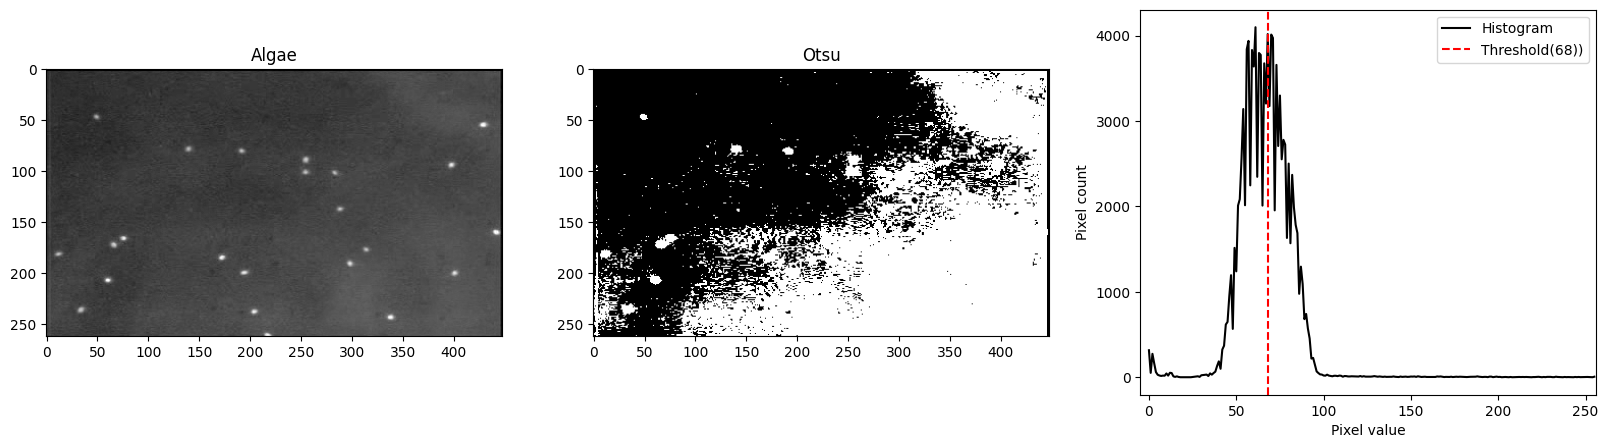

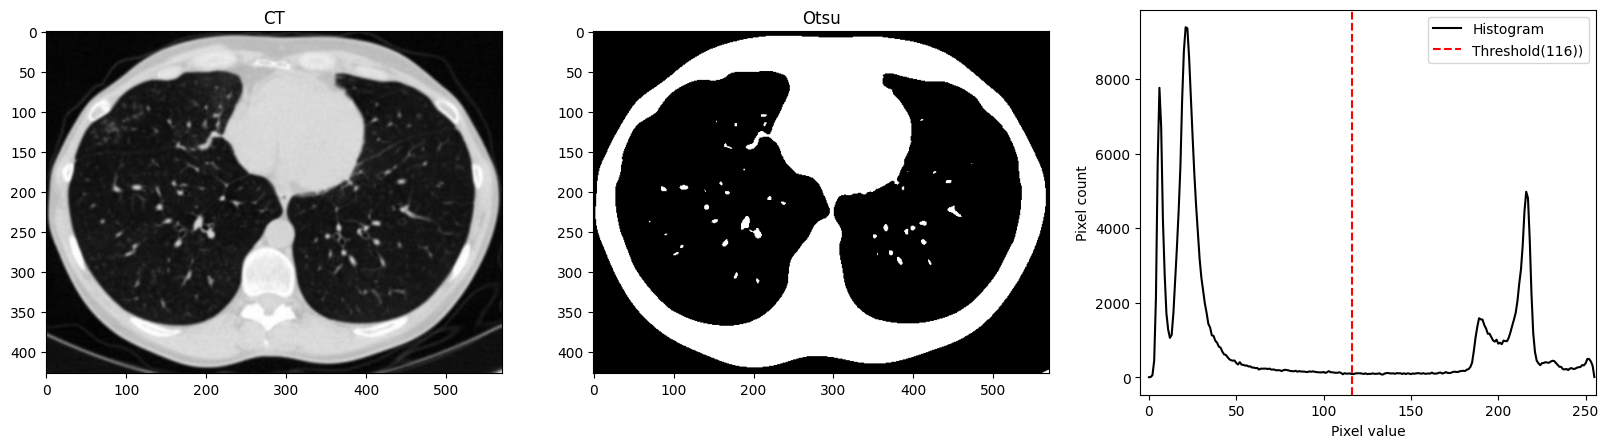

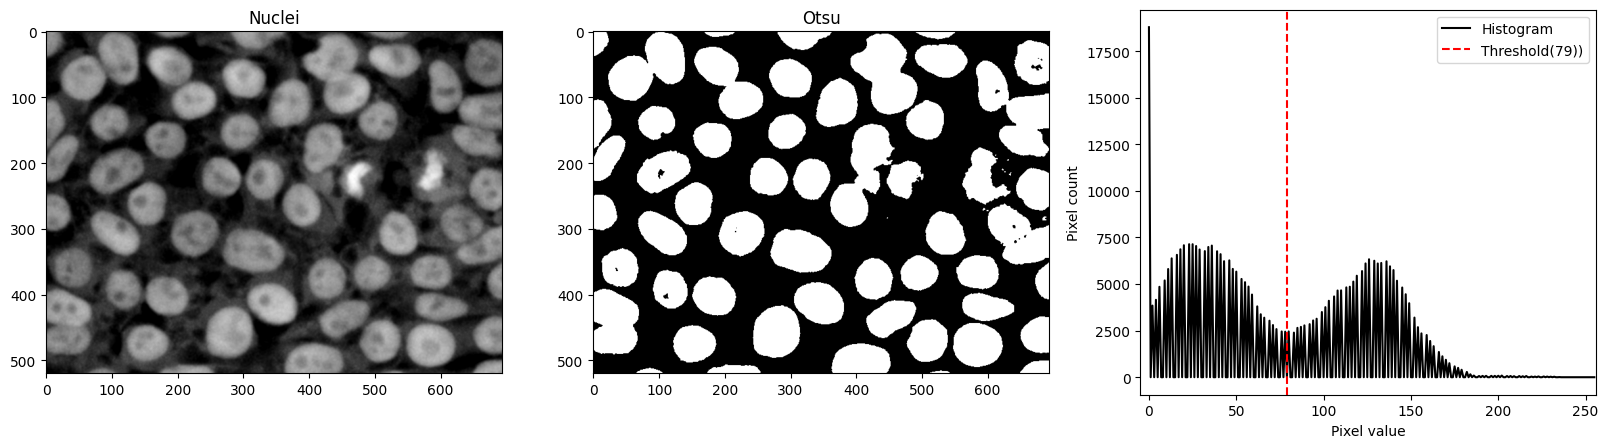

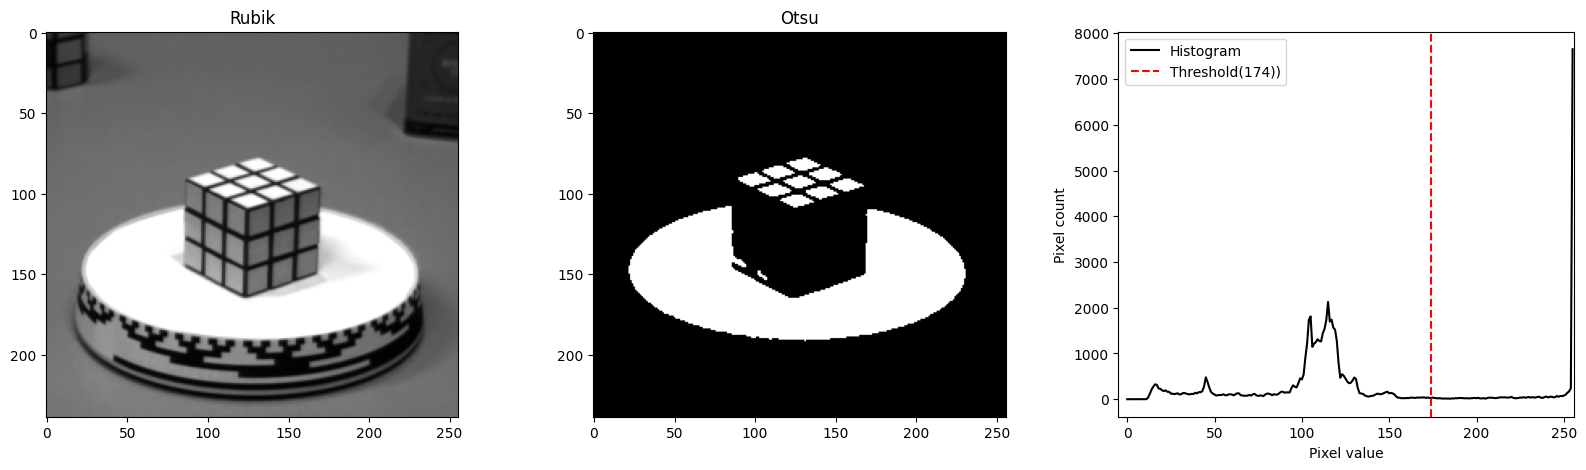

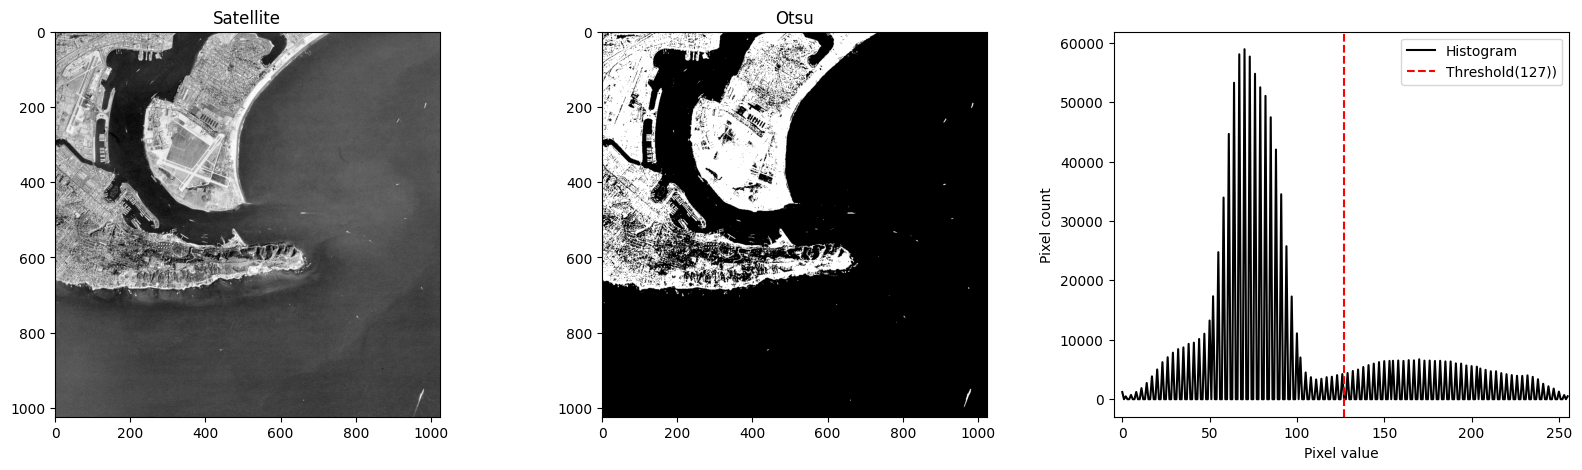

In [39]:
# Q1: Otsu Thresholding

import cv2
import numpy as np
from matplotlib import pyplot as plt


# Calculate histogram
def calcHist(I):
    hist = np.zeros(256, dtype=np.int32)
    for i in range(I.shape[0]):
        for j in range(I.shape[1]):
            hist[I[i, j]] += 1
    return hist


def Otsu(I):
    # Calculate the histogram of the image
    hist = calcHist(I)
    # Normalize the histogram
    hist_norm = hist.ravel() / hist.sum()
    # Initialize variables
    best_threshold = 0
    max_variance = 0
    # Traverse all thresholds
    for threshold in range(256):
        # Calculate the pixel probability and weight of category 1 and category 2
        weight1 = np.sum(hist_norm[:threshold])
        weight2 = np.sum(hist_norm[threshold:])

        # Calculate the mean of category 1 and category 2
        mean1 = np.sum(np.arange(threshold) * hist_norm[:threshold]) / (weight1 + 1e-5)
        mean2 = np.sum(np.arange(threshold, 256) * hist_norm[threshold:]) / (
            weight2 + 1e-5
        )

        # Calculate the inter-class variance
        variance = weight1 * weight2 * (mean1 - mean2) ** 2

        # Update the best threshold and maximum inter-class variance
        if variance > max_variance:
            max_variance = variance
            best_threshold = threshold

    # Apply the best threshold
    O = np.zeros_like(I)
    O[I > best_threshold] = 255
    return O, best_threshold


for input_file in ["Algae", "CT", "Nuclei", "Rubik", "Satellite"]:
    I = cv2.imread(f"{input_file}.png", cv2.IMREAD_GRAYSCALE)
    O, threshold = Otsu(I)

    # Display the input and output images of Otsu thresholding
    fig, axs = plt.subplots(1, 3, figsize=(20, 5))
    axs[0].imshow(I, cmap="gray")
    axs[0].set_title(f"{input_file}")
    axs[1].imshow(O, cmap="gray")
    axs[1].set_title("Otsu")
    axs[2].plot(calcHist(I), color="black")
    axs[2].axvline(x=threshold, color="red", linestyle="--")
    axs[2].set_xlabel("Pixel value")
    axs[2].set_ylabel("Pixel count")
    axs[2].legend(['Histogram', f'Threshold({threshold}))'])
    axs[2].set_xlim([-5, 256])

    # Save the output image
    cv2.imwrite(f"{input_file}_Otsu.png", O)

    plt.show()

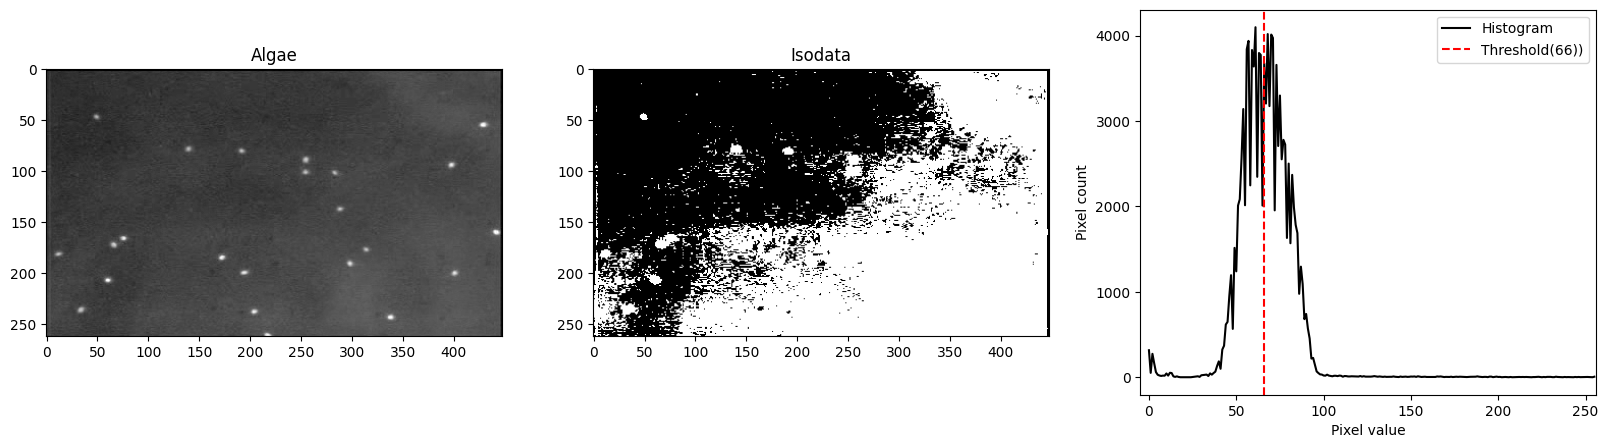

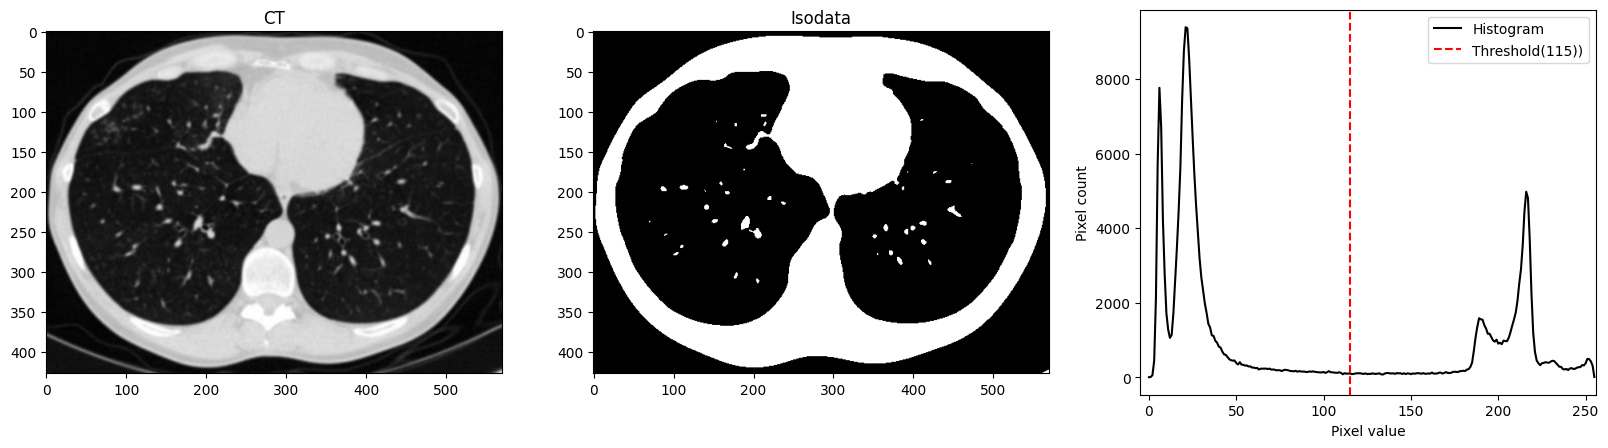

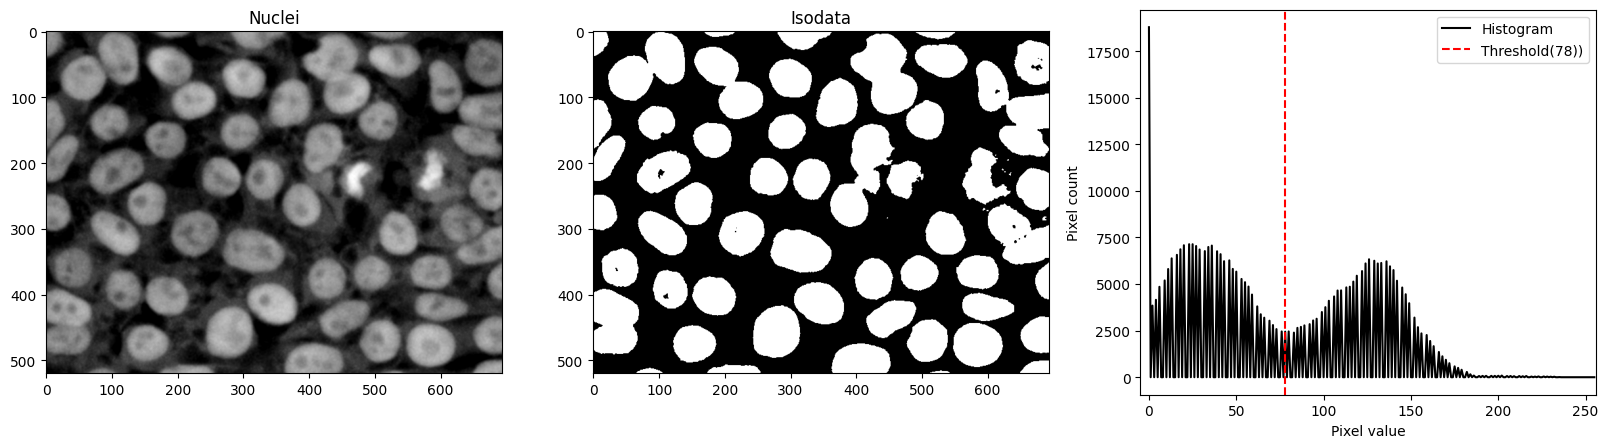

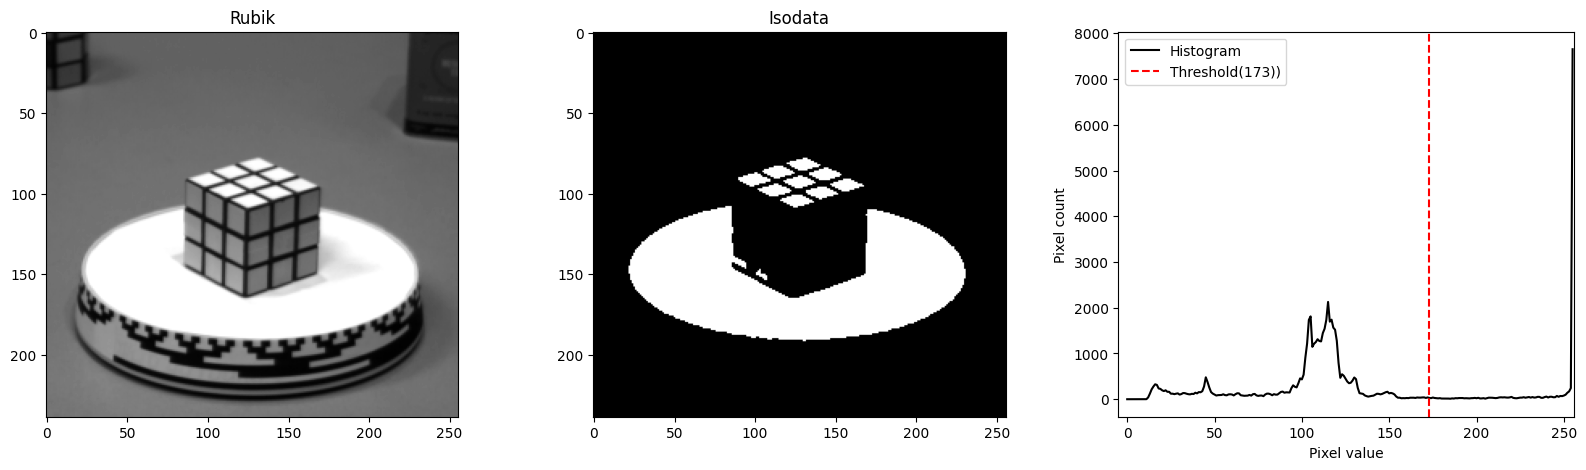

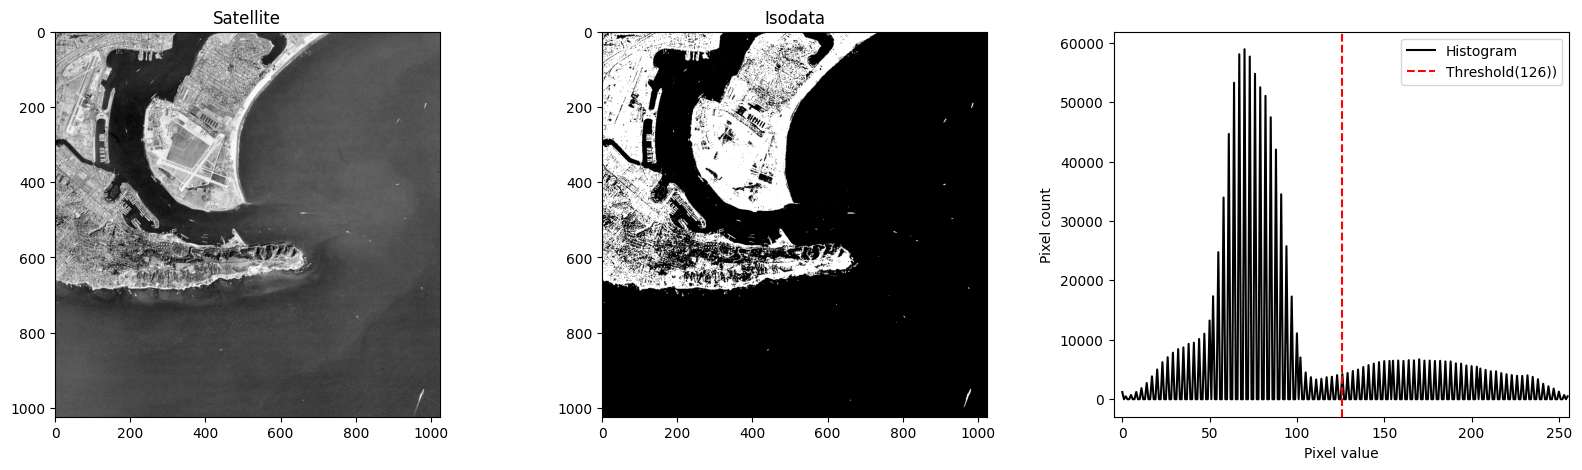

In [40]:
# Q2: Isodata Thresholding
import cv2
import numpy as np
from matplotlib import pyplot as plt

# Calculate histogram
def calcHist(I):
    hist = np.zeros(256, dtype=np.int32)
    for i in range(I.shape[0]):
        for j in range(I.shape[1]):
            hist[I[i,j]] += 1
    return hist

def Isodata(I):
    # Calculate the histogram of the image
    hist = calcHist(I)
    
    # Normalize the histogram
    hist_norm = hist.ravel() / hist.sum()
    
    # Initialize variables
    threshold = 0
    new_threshold = int(np.sum(np.arange(256) * hist_norm))
    
    # Convergence
    while threshold != new_threshold:
        threshold = new_threshold
        # Calculate the pixel probability and weight of category 1 and category 2
        weight1 = np.sum(hist_norm[:threshold])
        weight2 = np.sum(hist_norm[threshold:])
        # Calculate the mean of category 1 and category 2
        mean1 = np.sum(np.arange(threshold) * hist_norm[:threshold]) / (weight1 + 1e-5)
        mean2 = np.sum(np.arange(threshold, 256) * hist_norm[threshold:]) / (weight2 + 1e-5)
        # Calculate the new threshold
        new_threshold = int((mean1 + mean2) / 2)
        
    # Apply the best threshold
    O = np.zeros_like(I)
    O[I > new_threshold] = 255
    return O, new_threshold

for input_file in ["Algae", "CT", "Nuclei", "Rubik", "Satellite"]:
    I = cv2.imread(f"{input_file}.png", cv2.IMREAD_GRAYSCALE)
    O, threshold = Isodata(I)

    # Display the input and output images of Isodata thresholding
    fig, axs = plt.subplots(1, 3, figsize=(20, 5))
    axs[0].imshow(I, cmap="gray")
    axs[0].set_title(f"{input_file}")
    axs[1].imshow(O, cmap="gray")
    axs[1].set_title("Isodata")
    axs[2].plot(calcHist(I), color="black")
    axs[2].axvline(x=threshold, color="red", linestyle="--")
    axs[2].set_xlabel("Pixel value")
    axs[2].set_ylabel("Pixel count")
    axs[2].legend(['Histogram', f'Threshold({threshold}))'])
    axs[2].set_xlim([-5, 256])

    # Save the output image
    cv2.imwrite(f"{input_file}_Isodata.png", O)

    plt.show()


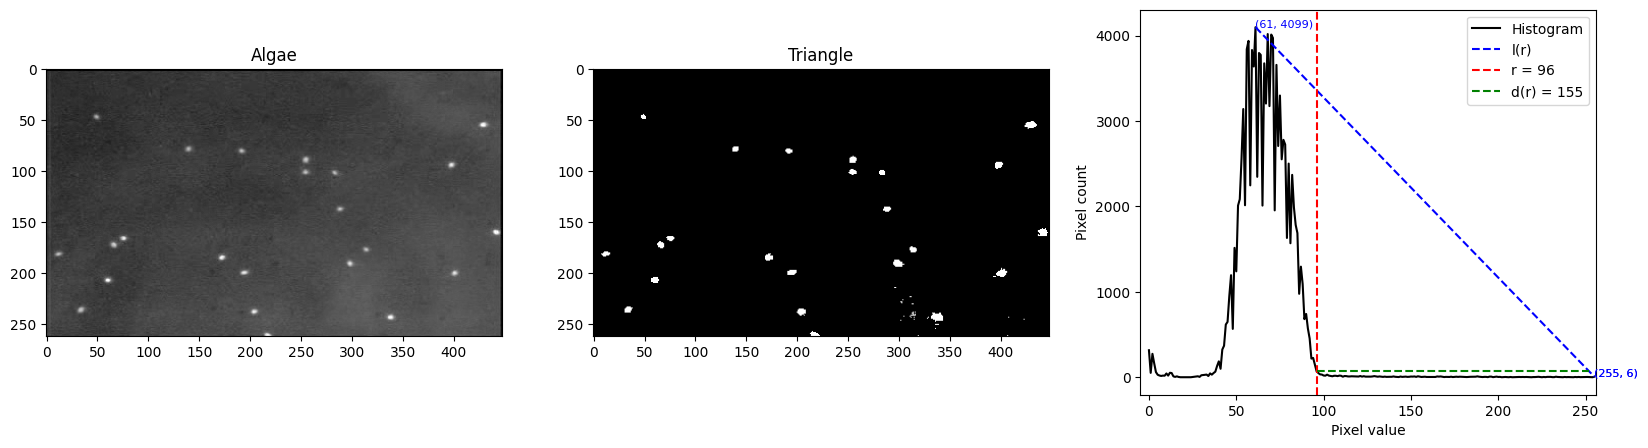

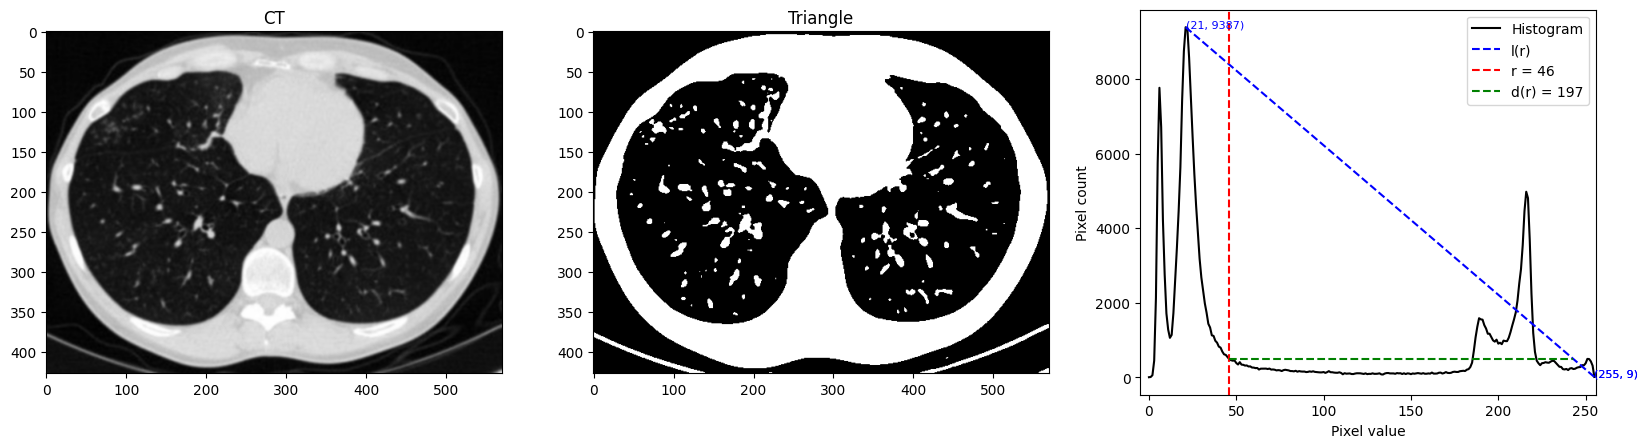

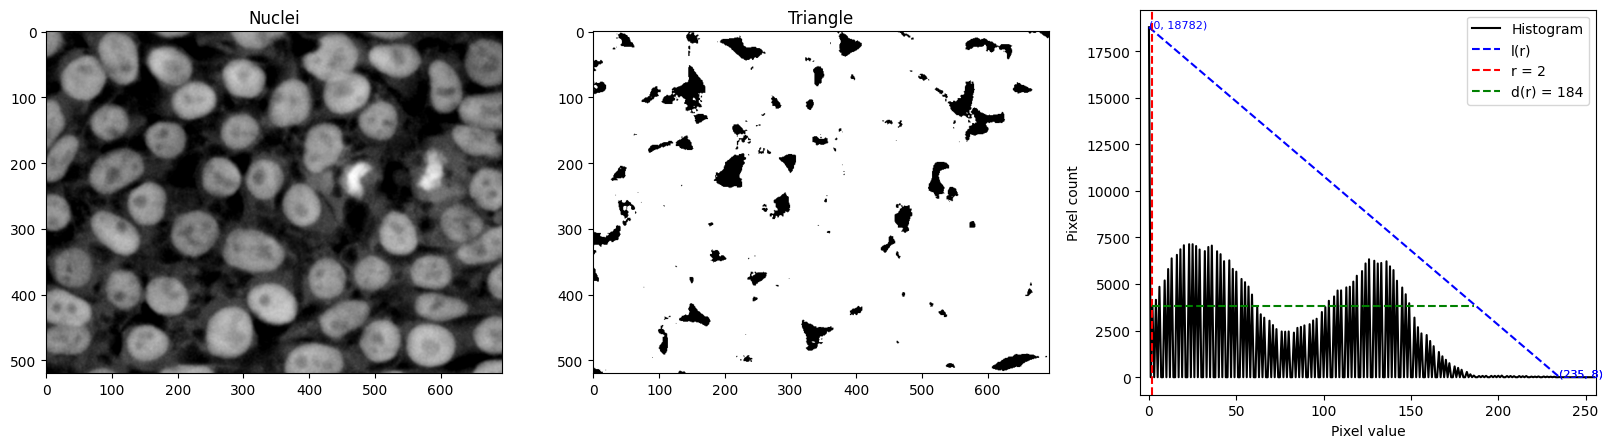

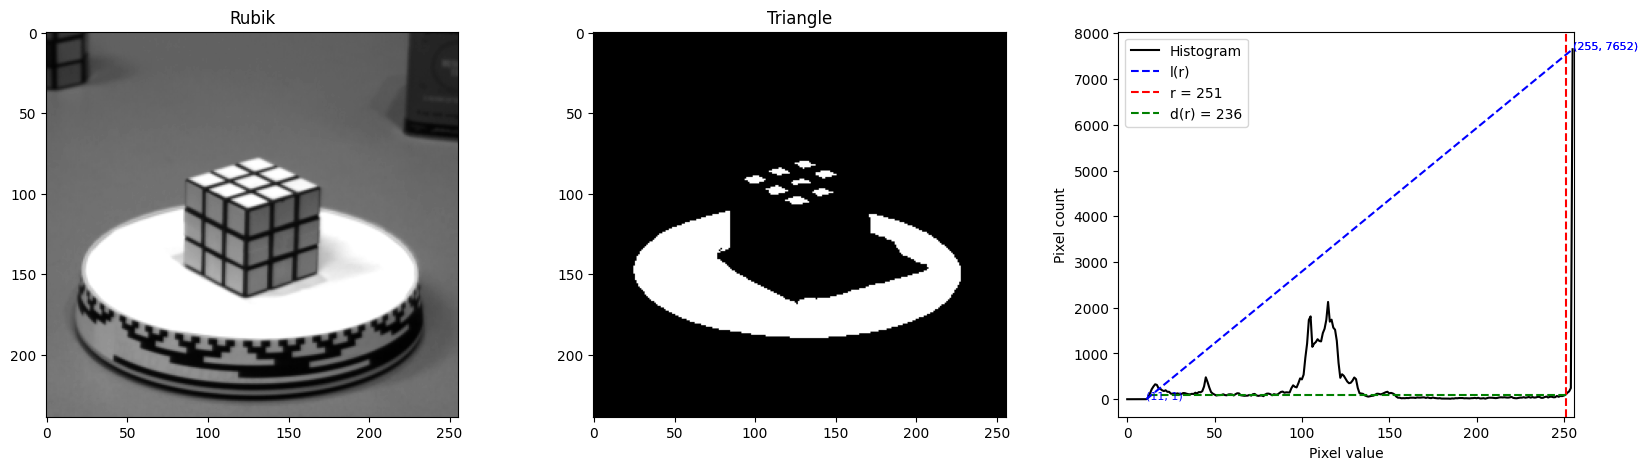

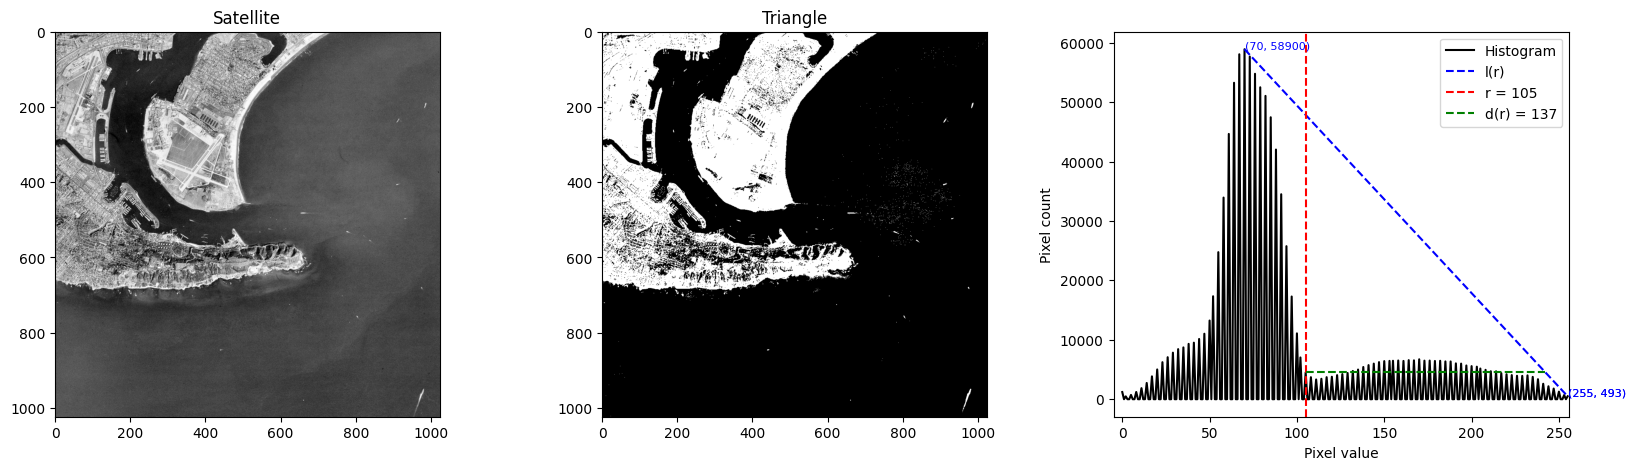

In [41]:
# Q3: Triangle Thresholding

import cv2
import numpy as np
import matplotlib.pyplot as plt


# Calculate histogram
def calcHist(I):
    hist = np.zeros(256, dtype=np.int32)
    for i in range(I.shape[0]):
        for j in range(I.shape[1]):
            hist[I[i, j]] += 1
    return hist


# Find the highest or lowest gray level, depending on the peak
def get_gray_level_point(hist, peak):
    if np.sum(hist[:peak]) > np.sum(hist[peak:]):
        # Traverse the histogram from both sides
        for i in range(256):
            if hist[i] != 0:
                return i
    else:
        for i in range(255, -1, -1):
            if hist[i] != 0:
                return i

def Triangle(I):
    # Calculate the histogram of the image
    hist = calcHist(I)

    # Find the peak of the histogram
    peak_gray = np.argmax(hist)
    peak_height = hist[peak_gray]

    # Find the highest gray level
    gray_level_point = get_gray_level_point(hist, peak_gray)
    gray_level_height = hist[gray_level_point]

    # Calculate the slope and intercept of the line between the peak and the highest gray level
    slope = (peak_height - gray_level_height) / (peak_gray - gray_level_point)
    intercept = peak_height - slope * peak_gray

    # Find the threshold where the distance between the line and the histogram is maximum
    max_distance = -1
    threshold = 0

    start = 0
    end = 255
    if gray_level_point > peak_gray:
        start = peak_gray
        end = gray_level_point
    else:
        start = gray_level_point
        end = peak_gray

    for t in range(start, end):
        if hist[t] == 0:
            continue
        distance = abs(slope * t - hist[t] + intercept) / np.sqrt(slope**2 + 1)
        if distance > max_distance:
            max_distance = distance
            threshold = t
            # calc_max_distance_intersection_point
            midpoint_x = (hist[t] - intercept) / slope
            midpoint_y = hist[t]


    # Apply the best threshold
    O = np.zeros_like(I)
    O[I > threshold] = 255

    return O, threshold, start, end, hist, int(midpoint_x), int(midpoint_y), int(max_distance)


for input_file in ["Algae", "CT", "Nuclei", "Rubik", "Satellite"]:
    I = cv2.imread(f"{input_file}.png", cv2.IMREAD_GRAYSCALE)
    O, threshold, start, end, hist, midpoint_x, midpoint_y, distance = Triangle(I)

    # Display the input and output images of Triangle thresholding
    fig, axs = plt.subplots(1, 3, figsize=(20, 5))
    axs[0].imshow(I, cmap="gray")
    axs[0].set_title(f"{input_file}")
    axs[1].imshow(O, cmap="gray")
    axs[1].set_title("Triangle")
    axs[2].plot(calcHist(I), color="black")
    axs[2].plot([start, end], [hist[start], hist[end]], color="blue", linestyle="--")
    axs[2].axvline(x=threshold, color="red", linestyle="--")
    axs[2].plot(
        [threshold, midpoint_x],
        [hist[threshold], midpoint_y],
        color="green",
        linestyle="--",
    )
    axs[2].text(start, hist[start], f"({start}, {hist[start]})", color='blue', fontsize=8)
    axs[2].text(end, hist[end], f"({end}, {hist[end]})", color='blue', fontsize=8)
    axs[2].text(end, hist[end], f"({end}, {hist[end]})", color='blue', fontsize=8)
    axs[2].set_xlabel("Pixel value")
    axs[2].set_ylabel("Pixel count")
    axs[2].legend(["Histogram", "l(r)", f"r = {threshold}", f"d(r) = {distance}"])
    axs[2].set_xlim([-5, 256])

    # Save the output image
    cv2.imwrite(f"{input_file}_Triangle.png", O)

    plt.show()

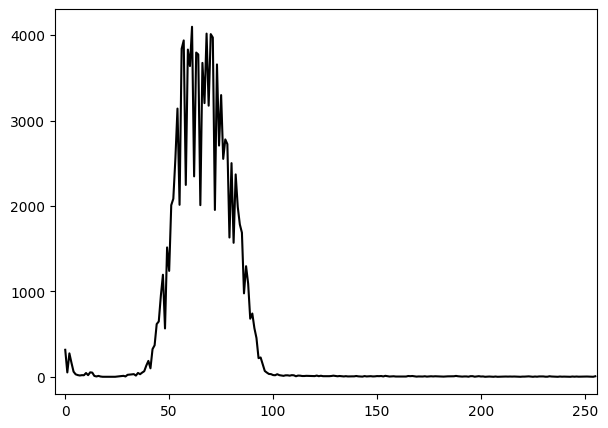

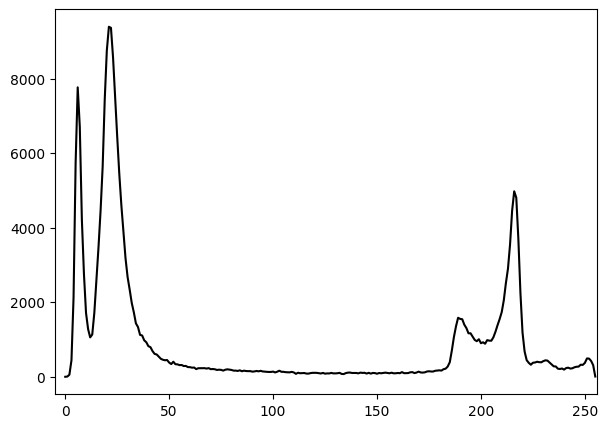

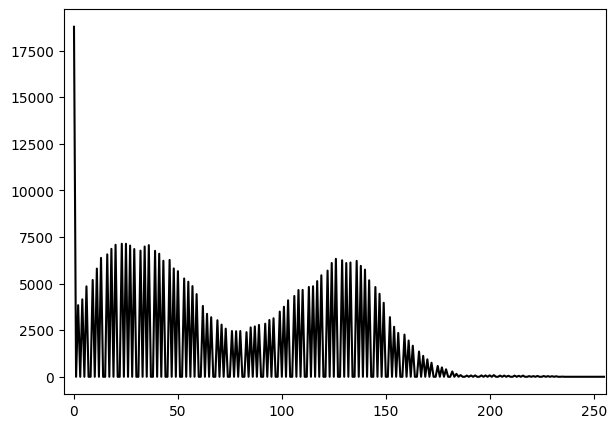

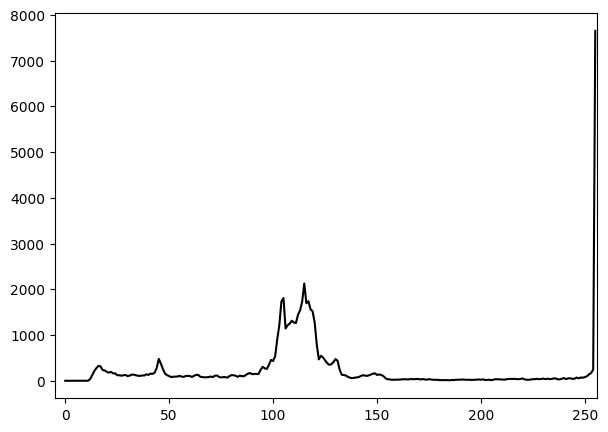

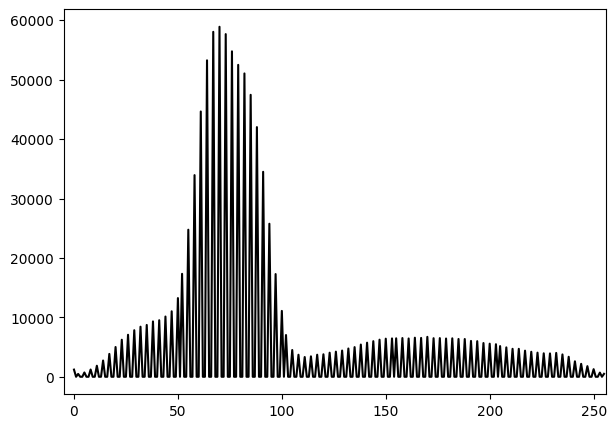

In [42]:
# Histogram for report

import cv2
import numpy as np
import matplotlib.pyplot as plt


def calcHist(I):
    hist = np.zeros(256, dtype=np.int32)
    for i in range(I.shape[0]):
        for j in range(I.shape[1]):
            hist[I[i, j]] += 1
    return hist

for input_file in ["Algae", "CT", "Nuclei", "Rubik", "Satellite"]:
    I = cv2.imread(f"{input_file}.png", cv2.IMREAD_GRAYSCALE)

    # Display the input and output images of Otsu thresholding
    fig, axs = plt.subplots(figsize=(7, 5))
    axs.plot(calcHist(I), color="black")
    axs.set_xlim([-5, 256])

    # Save the output image
    plt.savefig(f"{input_file}_Hist.png")
    plt.show()
    
    